# Common Visualizations Notebook 

### To make loading xgb bundle easier:

In [1]:
# Fake xgboost so pickling works without real binary
import sys
import types

fake_xgb = types.ModuleType("xgboost")

class FakeBooster:
    def __init__(self, *args, **kwargs):
        pass

    def __setstate__(self, state):
        # Just store whatever is in the pickle, don't call any C code
        self.__dict__.update(state)

    def __getstate__(self):
        return self.__dict__

class FakeXGBClassifier:
    def __init__(self, *args, **kwargs):
        pass

    def __setstate__(self, state):
        self.__dict__.update(state)

    def __getstate__(self):
        return self.__dict__

# Attach fake classes to fake xgboost module
fake_xgb.Booster = FakeBooster
fake_xgb.XGBClassifier = FakeXGBClassifier

# Some pickles may refer to submodules like xgboost.core or xgboost.sklearn
fake_core = types.ModuleType("xgboost.core")
fake_core.Booster = FakeBooster

fake_sklearn = types.ModuleType("xgboost.sklearn")
fake_sklearn.XGBClassifier = FakeXGBClassifier

# Register all of them so pickle can resolve imports
sys.modules["xgboost"] = fake_xgb
sys.modules["xgboost.core"] = fake_core
sys.modules["xgboost.sklearn"] = fake_sklearn

print("Fake xgboost modules registered successfully.")


Fake xgboost modules registered successfully.


### Library Import Station

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


sns.set(style="whitegrid", font_scale=1.1)



In [3]:
# 1. Point to the folder where all your bundles live 
# (change this if needed)
BUNDLE_DIR = "../../Results/Pickle_Bundles"

# Map: pretty model name -> pickle filename
model_files = {
    "Logistic Regression": "logreg_bundle.pkl",
    "Naive Bayes"        : "nbc_bundle.pkl",
    "KNN"                : "knn_bundle.pkl",
    "XGBoost"            : "xgb_bundle.pkl",
    "Random Forest"      : "rf_bundle.pkl",
    "Decision Tree"      : "decision_tree_bundle.pkl",
    "Linear SVM"         : "linear_svm_bundle.pkl",
}

# 2. Load all bundles into a dict 
bundles = {}

for model_name, filename in model_files.items():
    bundle_path = os.path.join(BUNDLE_DIR, filename)
    with open(bundle_path, "rb") as f:
        bundle = pickle.load(f)
    bundles[model_name] = bundle
    print(f"{model_name} loaded from {filename}")
    print("  keys:", bundle.keys())
    print()

# For this project, classes are DIABETE4 = {1, 3, 4}
class_labels = [1, 3, 4]
class_label_str = ["1", "3", "4"]  # for axis tick labels

Logistic Regression loaded from logreg_bundle.pkl
  keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'coef', 'intercept', 'lr_feature_names', 'feature_names', 'X_test_sample', 'best_lr_model'])

Naive Bayes loaded from nbc_bundle.pkl
  keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'best_score_f1_macro', 'cv_results', 'feature_names', 'X_test_sample', 'best_nb_model', 'classes'])



/opt/miniconda3/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


KNN loaded from knn_bundle.pkl
  keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'feature_names', 'X_test_sample', 'subsample_fraction', 'val_f1_p1', 'val_f1_p2', 'best_params_p1', 'best_score_p1', 'best_params_p2', 'best_score_p2', 'cv_results_p1', 'cv_results_p2', 'k_values', 'knn_p1_model', 'knn_p2_model'])

XGBoost loaded from xgb_bundle.pkl
  keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'log_loss', 'roc_auc_ovr', 'params', 'xgb_feature_importance_gain', 'xgb_feature_names', 'xgb_shap_values', 'xgb_shap_expected_value', 'xgb_shap_X', 'feature_names', 'X_test_sample', 'xgb_best_model'])

Random Forest loaded from rf_bundle.pkl
  keys: dict_keys(['model_name', 'y_test', 'y_pred', 'y_proba', 'confusion_matrix', 'accuracy', 'precision_macro', 'recall_macro', 'f1_m

## CONFUSION MATRIX SUMMARY

### Figure A: Grid of confusion matrices for all models

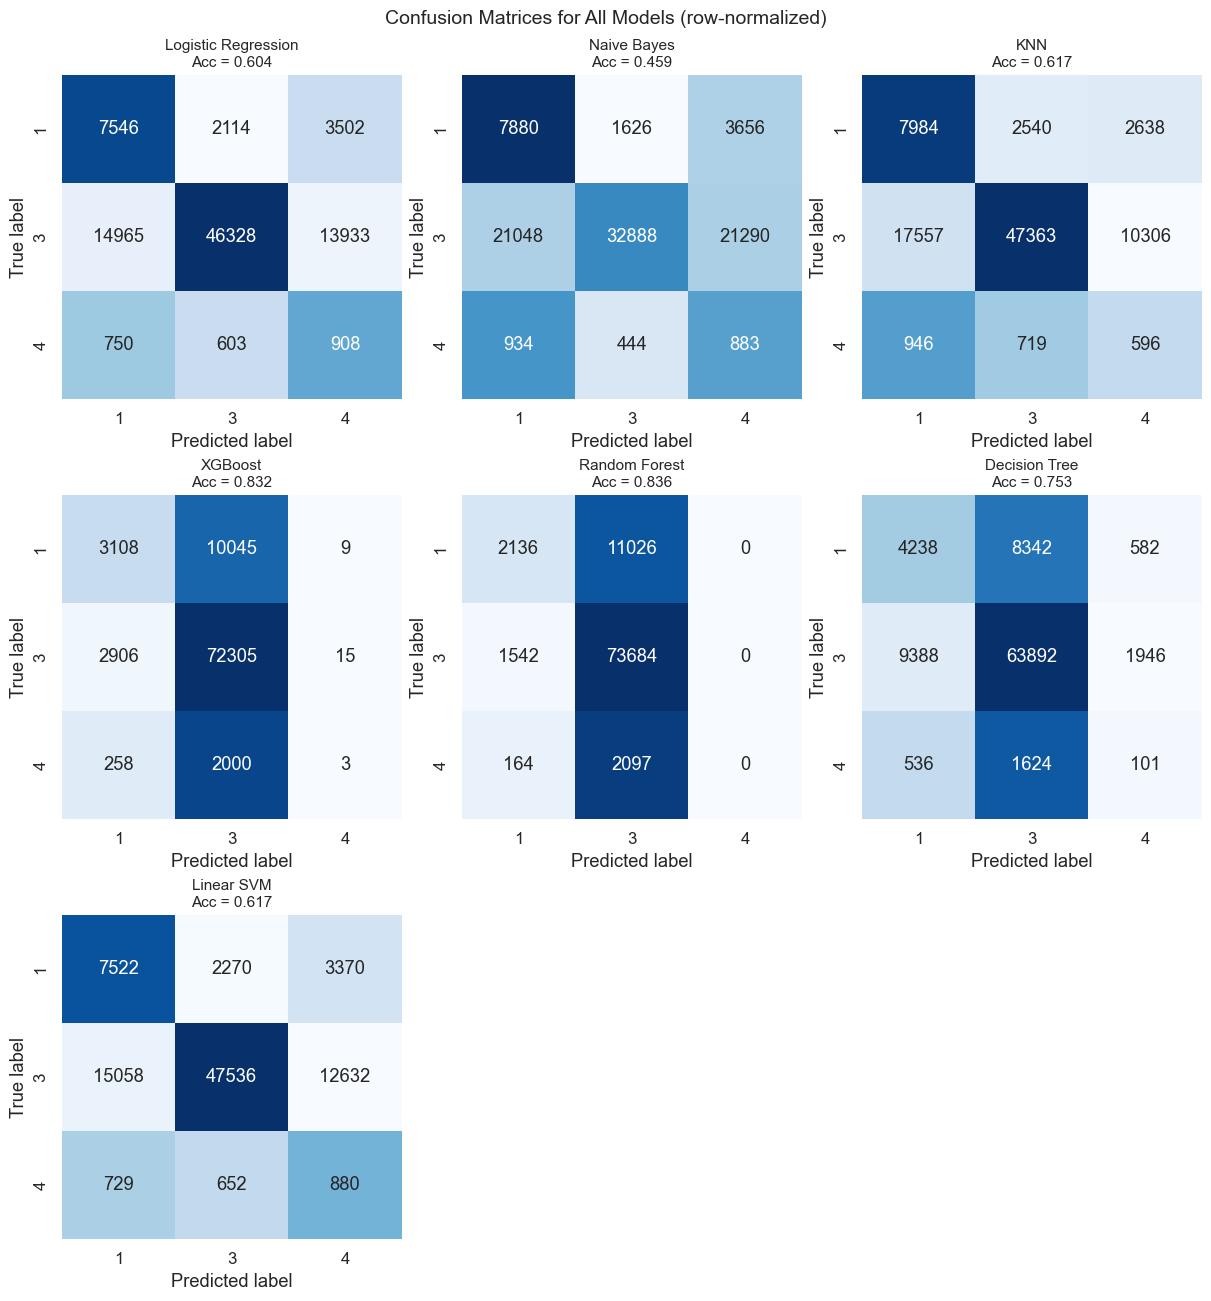

In [4]:
n_models = len(bundles)
n_cols = 3   # 3 columns looks reasonable
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 4.2 * n_rows),
    constrained_layout=True
)

# Make axes array 2D for easy indexing
axes = np.array(axes).reshape(n_rows, n_cols)

for idx, (model_name, bundle) in enumerate(bundles.items()):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    cm = np.array(bundle["confusion_matrix"])
    # Row-normalize to get proportions per true class
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    # Heatmap with raw counts as annotations
    sns.heatmap(
        cm_norm,
        annot=cm,           # show raw counts
        fmt="g",
        cmap="Blues",
        cbar=False,
        xticklabels=class_label_str,
        yticklabels=class_label_str,
        ax=ax
    )

    acc = bundle.get("accuracy", None)
    if acc is not None:
        title = f"{model_name}\nAcc = {acc:.3f}"
    else:
        title = model_name
    ax.set_title(title, fontsize=11)

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

# Turn off any unused subplots (if grid bigger than #models)
for idx in range(n_models, n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

fig.suptitle("Confusion Matrices for All Models (row-normalized)", fontsize=14, y=1.02)
plt.savefig("../../Results/Visualizations/Final_visualizations/Summary_confusion_matrix_grid.png", dpi=300, bbox_inches="tight")
plt.show()


## Figure B: Per-class Recall Heatmap Across Models

Per-class recall:
                             1         3         4
Logistic Regression  0.573317  0.615851  0.401592
Naive Bayes          0.598693  0.437189  0.390535
KNN                  0.606595  0.629609  0.263600
XGBoost              0.236134  0.961170  0.001327
Random Forest        0.162285  0.979502  0.000000
Decision Tree        0.321988  0.849334  0.044670
Linear SVM           0.571494  0.631909  0.389208


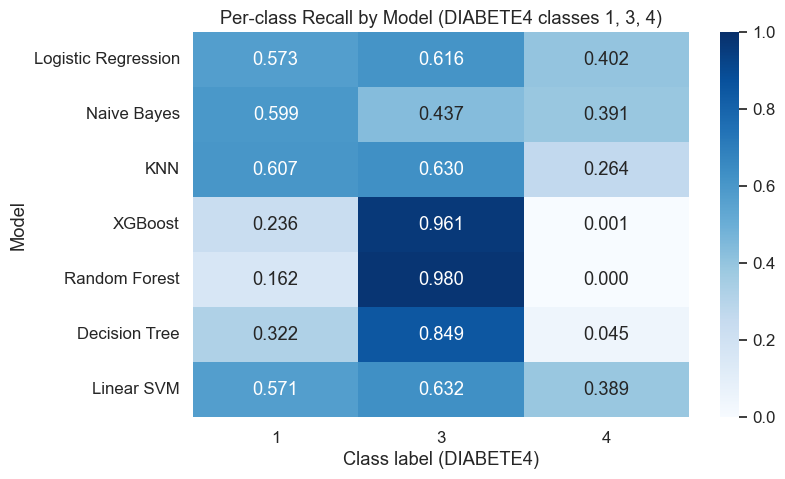

In [5]:
rows = []

for model_name, bundle in bundles.items():
    cm = np.array(bundle["confusion_matrix"])
    # sanity check
    if cm.shape != (3, 3):
        raise ValueError(f"{model_name}: expected 3x3 confusion matrix, got {cm.shape}")

    # recall per class: diagonal / row sum
    recalls = cm.diagonal() / cm.sum(axis=1)
    row = pd.Series(recalls, index=class_label_str, name=model_name)
    rows.append(row)

recall_df = pd.DataFrame(rows)

print("Per-class recall:\n", recall_df)

plt.figure(figsize=(8, 5))
sns.heatmap(
    recall_df,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    vmin=0.0,
    vmax=1.0
)
plt.title("Per-class Recall by Model (DIABETE4 classes 1, 3, 4)")
plt.xlabel("Class label (DIABETE4)")
plt.ylabel("Model")
plt.yticks(rotation=0)
plt.savefig("../../Results/Visualizations/Final_visualizations/Summary_Per_class_recall_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()


## Figure C – Interactive confusion-matrix explorer (Plotly)

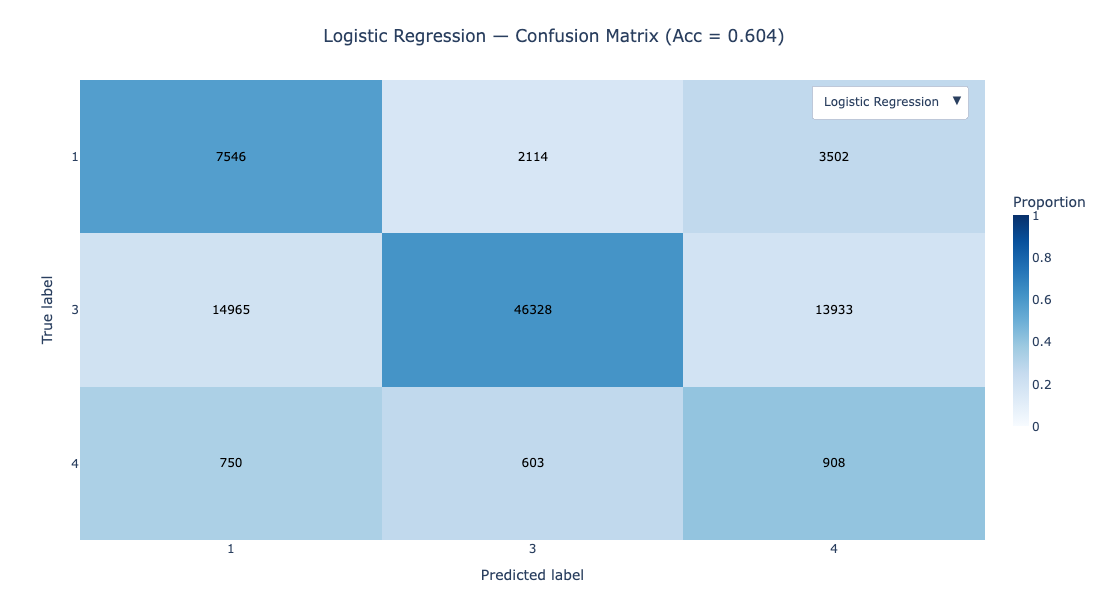

Saved interactive confusion-matrix explorer to: ../../docs/Interactive_CM_Explorer.html


In [6]:
# 1. Prepare data from bundles 

model_names = [
    "Logistic Regression",
    "Naive Bayes",
    "KNN",
    "XGBoost",
    "Random Forest",
    "Decision Tree",
    "Linear SVM",
]

class_labels = [1, 3, 4]
class_labels_str = [str(c) for c in class_labels]

cm_dict = {}
cm_norm_dict = {}
acc_dict = {}

for model_name in model_names:
    bundle = bundles[model_name]
    cm = np.array(bundle["confusion_matrix"])
    cm_dict[model_name] = cm

    # Row-normalize to get proportions per true class
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm_dict[model_name] = cm_norm

    acc = float(bundle.get("accuracy", np.nan))
    acc_dict[model_name] = acc

# 2. Initial heatmap (use text inside cells instead of annotations) ----

initial_model = model_names[0]
cm0 = cm_dict[initial_model]
cm0_norm = cm_norm_dict[initial_model]
cm0_text = cm0.astype(str)

title0 = f"{initial_model} — Confusion Matrix (Acc = {acc_dict[initial_model]:.3f})"

heatmap = go.Heatmap(
    z=cm0_norm,
    x=class_labels_str,          # predicted labels
    y=class_labels_str,          # true labels
    colorscale="Blues",
    zmin=0,
    zmax=1,
    colorbar=dict(
        title="Proportion",
        thickness=16,
        len=0.55,
        y=0.5,
    ),
    text=cm0_text,               # raw counts
    texttemplate="%{text}",      # show text exactly
    textfont=dict(color="black", size=12),
    hovertemplate=(
        "True: %{y}<br>"
        "Predicted: %{x}<br>"
        "Count: %{text}<br>"
        "Proportion: %{z:.3f}<extra></extra>"
    ),
)

fig = go.Figure(data=[heatmap])

# 3. Dropdown to switch models 

buttons = []
for name in model_names:
    cm = cm_dict[name]
    cm_norm = cm_norm_dict[name]
    cm_text = cm.astype(str)
    title = f"{name} — Confusion Matrix (Acc = {acc_dict[name]:.3f})"

    buttons.append(
        dict(
            label=name,
            method="update",
            args=[
                {
                    "z": [cm_norm],       # update normalized values
                    "text": [cm_text],    # update counts in cells
                },
                {
                    "title.text": title,  # update title
                },
            ],
        )
    )

fig.update_layout(
    title=dict(text=title0, x=0.5, y=0.95, xanchor="center"),
    xaxis=dict(
        title="Predicted label",
        tickmode="array",
        tickvals=class_labels_str,
        ticktext=class_labels_str,
        constrain="domain",
    ),
    yaxis=dict(
        title="True label",
        tickmode="array",
        tickvals=class_labels_str,
        ticktext=class_labels_str,
        autorange="reversed",    # put class 1 at top like seaborn
    ),
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            showactive=True,
            x=0.98,
            xanchor="right",
            y=0.99,
            yanchor="top",
        )
    ],
    width=650,
    height=600,
    plot_bgcolor="white",
    paper_bgcolor="white",
    margin=dict(l=80, r=120, t=80, b=60),
)

fig.show()


# Save interactive HTML file


# save a static PNG if you want one for the paper/README
fig.write_image("../../Results/Visualizations/Final_visualizations/Interactive_CM_Explorer.png")

# Convert the Plotly figure to a full HTML document (with Plotly JS from CDN)
html_content = fig.to_html(
    include_plotlyjs="cdn",
    full_html=True
)

# Add an interpretation panel below the figure
interpretation_html = """
<div style="margin-top: 20px; font-family: Arial; font-size: 15px; line-height: 1.6;">
  <h3>Interpretation: Interactive Confusion-Matrix Explorer</h3>
  <p>
    This interactive heatmap lets you compare confusion matrices across all trained classifiers.
    Use the dropdown menu at the top to switch between models; the color of each cell shows the
    <b>proportion</b> of predictions for that true class, while the numbers inside the cells show the
    <b>raw counts</b>. Darker squares along the diagonal correspond to correct predictions, whereas
    off-diagonal cells highlight specific misclassifications between classes 1 (No diabetes),
    3 (Prediabetes), and 4 (Diabetes). The matrices reveal substantial differences in class-specific performance across models, 
    with tree-based methods (XGBoost and Random Forest) showing extremely high recall for class 3 but weaker identification of class 4, 
    while linear models (Logistic Regression and SVM) provide more balanced—but overall lower—performance across classes.
  </p>
  <p>
    By exploring the dropdown, you can see how different models trade off between correctly identifying
    prediabetes versus diabetes and where they systematically confuse classes, going beyond what a single
    summary metric like accuracy can reveal.
  </p>
</div>
"""

# Inject the interpretation block before the closing </body> tag
final_html = html_content.replace("</body>", interpretation_html + "</body>")

# Write out the final HTML file into the docs/ folder
output_path = "../../docs/Interactive_CM_Explorer.html"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(final_html)

print(f"Saved interactive confusion-matrix explorer to: {output_path}")



## ROC CURVES SUMMARY

Logistic Regression: built ROC from y_proba, macro AUC = 0.763
Naive Bayes: built ROC from y_proba, macro AUC = 0.635
KNN: built ROC from y_proba, macro AUC = 0.791
XGBoost: built ROC from y_proba, macro AUC = 0.947
Random Forest: built ROC from y_proba, macro AUC = 0.948
Decision Tree: built ROC from y_proba, macro AUC = 0.815
Linear SVM: built ROC from y_scores, macro AUC = 0.765


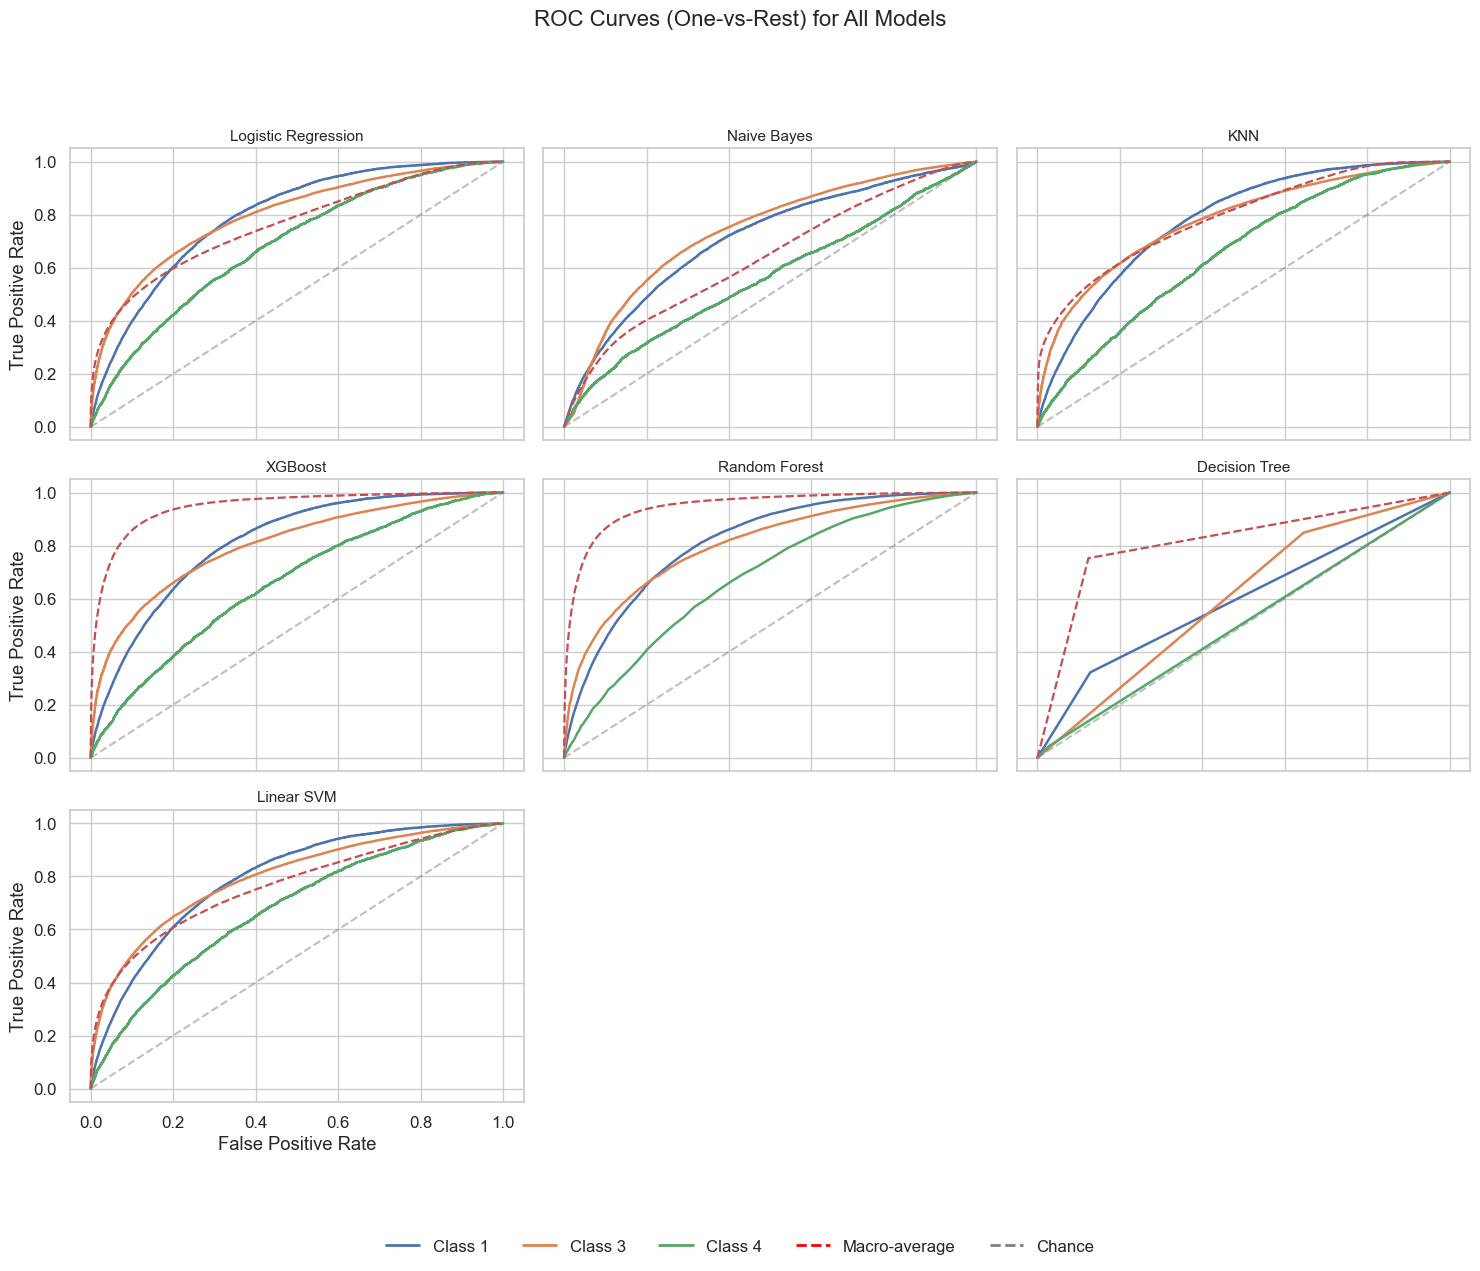

In [7]:
# ROC grid for all models 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Keep the same order you used when loading bundles
model_order = [
    "Logistic Regression",
    "Naive Bayes",
    "KNN",
    "XGBoost",
    "Random Forest",
    "Decision Tree",
    "Linear SVM",
]

roc_curves = {}

for model_name in model_order:
    bundle = bundles[model_name]
    y_test = np.asarray(bundle["y_test"])

    # Use y_scores for SVM (this is what you used in your original SVM ROC),
    # y_proba for all other models
    if model_name == "Linear SVM":
        scores = np.asarray(bundle["y_scores"])
        source = "y_scores"
    else:
        scores = np.asarray(bundle["y_proba"])
        source = "y_proba"

    # Ensure 2D shape: (n_samples, n_classes)
    if scores.ndim == 1:
        scores = scores.reshape(-1, 1)

    # Classes and one-vs-rest binarization
    classes = np.unique(y_test)          # should be [1, 3, 4]
    y_bin = label_binarize(y_test, classes=classes)

    per_class = []
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], scores[:, i])
        per_class.append({
            "cls": cls,
            "fpr": fpr,
            "tpr": tpr,
            "auc": auc(fpr, tpr),
        })

    # "Macro" curve here is actually a pooled (micro-like) average,
    # which matches what you plotted before.
    fpr_macro, tpr_macro, _ = roc_curve(y_bin.ravel(), scores.ravel())
    auc_macro = auc(fpr_macro, tpr_macro)

    roc_curves[model_name] = {
        "classes": classes,
        "per_class": per_class,
        "fpr_macro": fpr_macro,
        "tpr_macro": tpr_macro,
        "auc_macro": auc_macro,
    }

    print(f"{model_name}: built ROC from {source}, macro AUC = {auc_macro:.3f}")

# Plot grid of ROC curves 

n_models = len(model_order)
n_cols = 3
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 4 * n_rows),
    sharex=True,
    sharey=True,
)
axes = np.array(axes).reshape(n_rows, n_cols)

for idx, model_name in enumerate(model_order):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    data = roc_curves[model_name]

    # Per-class curves
    for pc in data["per_class"]:
        ax.plot(
            pc["fpr"],
            pc["tpr"],
            lw=1.8,
            label=f"Class {pc['cls']} (AUC = {pc['auc']:.3f})",
        )

    # Macro / pooled curve
    ax.plot(
        data["fpr_macro"],
        data["tpr_macro"],
        "r--",
        lw=1.6,
        label=f"Macro-average (AUC = {data['auc_macro']:.3f})",
    )

    # Chance line
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.5, label="Chance")

    ax.set_title(model_name, fontsize=11)
    if row == n_rows - 1:
        ax.set_xlabel("False Positive Rate")
    if col == 0:
        ax.set_ylabel("True Positive Rate")

# Turn off any unused panels (since 3×3 grid has 9 slots, 7 models)
for idx in range(n_models, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    fig.delaxes(axes[row, col])

# CLEAN GLOBAL LEGEND (no AUC values)

clean_handles = []
clean_labels = []

# Colors match matplotlib default cycle
import matplotlib.pyplot as plt
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 3 per-class curves
clean_handles.append(
    plt.Line2D([0], [0], color=default_colors[0], lw=2)
)
clean_labels.append("Class 1")

clean_handles.append(
    plt.Line2D([0], [0], color=default_colors[1], lw=2)
)
clean_labels.append("Class 3")

clean_handles.append(
    plt.Line2D([0], [0], color=default_colors[2], lw=2)
)
clean_labels.append("Class 4")

# Macro-average (red dashed)
clean_handles.append(
    plt.Line2D([0], [0], color="red", lw=2, linestyle="--")
)
clean_labels.append("Macro-average")

# Chance (gray dashed)
clean_handles.append(
    plt.Line2D([0], [0], color="gray", lw=2, linestyle="--")
)
clean_labels.append("Chance")

fig.legend(
    clean_handles,
    clean_labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=5,
    frameon=False
)


fig.suptitle("ROC Curves (One-vs-Rest) for All Models", fontsize=16, y=1.02)
fig.tight_layout(rect=(0, 0.05, 1, 0.97))
plt.show()


# Interactive Model Comparison

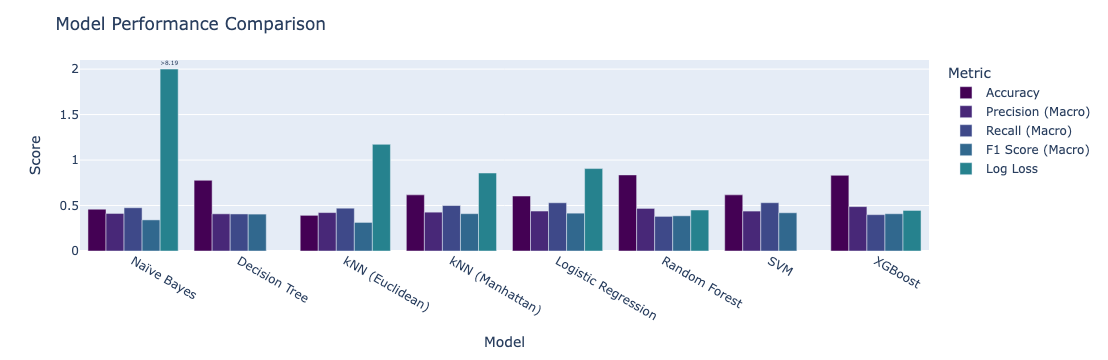

Saved interactive model comparison to: ../../docs/Interactive_Model_Comparison.html


In [8]:
import pandas as pd
import numpy as np
import plotly.express as px

# --- Metrics table (skip this block if df_metrics already exists in your notebook) ---
data = {
    "Model": [
        "Naïve Bayes",
        "Decision Tree",
        "kNN (Euclidean)",
        "kNN (Manhattan)",
        "Logistic Regression",
        "Random Forest",
        "SVM",
        "XGBoost"
    ],
    "Accuracy": [
        0.4594, 0.7772, 0.3921, 0.6171, 0.6043,
        0.8364, 0.6171, 0.8320
    ],
    "Precision (Macro)": [
        0.4129, 0.4087, 0.4223, 0.4270, 0.4395,
        0.4683, 0.4390, 0.4879
    ],
    "Recall (Macro)": [
        0.4754, 0.4072, 0.4706, 0.4999, 0.5303,
        0.3806, 0.5309, 0.3995
    ],
    "F1 Score (Macro)": [
        0.3420, 0.4057, 0.3142, 0.4103, 0.4160,
        0.3869, 0.4203, 0.4096
    ],
    "Log Loss": [
        8.1898, None, 1.1728, 0.8575, 0.9061,
        0.4508, None, 0.4458
    ]
}

df_metrics = pd.DataFrame(data)

# --- Long format ---
df_melt = df_metrics.melt(id_vars="Model", var_name="Metric", value_name="Value")
df_melt = df_melt.dropna(subset=["Value"])

# --- Clip values for plotting, keep true values for hover ---
y_max = 2.0
df_melt["PlotValue"] = df_melt["Value"].clip(upper=y_max)

# Text only for Naïve Bayes Log Loss
def make_label(row):
    if row["Model"] == "Naïve Bayes" and row["Metric"] == "Log Loss":
        # show clipped notation if needed
        return f">{row['Value']:.2f}" if row["Value"] > y_max else f"{row['Value']:.2f}"
    else:
        return ""

df_melt["BarLabel"] = df_melt.apply(make_label, axis=1)

# --- Interactive bar plot (Viridis colors, hover shows true values) ---
fig = px.bar(
    df_melt,
    x="Model",
    y="PlotValue",
    color="Metric",
    barmode="group",
    text="BarLabel",
    custom_data=["Metric", "Value"],
    color_discrete_sequence=px.colors.sequential.Viridis  # matches original palette vibe
)

fig.update_traces(
    textposition="outside",
    hovertemplate=(
        "Model: %{x}<br>"
        "Metric: %{customdata[0]}<br>"
        "Value: %{customdata[1]:.4f}<extra></extra>"
    )
)

fig.update_layout(
    title="Model Performance Comparison",
    xaxis_title="Model",
    yaxis_title="Score",
    yaxis=dict(range=[0, y_max + 0.1]),
    legend_title="Metric",
    bargap=0.15,
)

fig.show()

# Save interactive HTML file


# static PNG for non-interactive contexts
fig.write_image("../../Results/Visualizations/Final_visualizations/Interactive_Model_Comparison.png")

# Convert Plotly figure to full HTML (with Plotly JS from CDN)
html_content = fig.to_html(
    include_plotlyjs="cdn",
    full_html=True
)

# Interpretation block to append under the figure
interpretation_html = """
<div style="margin-top: 20px; font-family: Arial; font-size: 15px; line-height: 1.6;">
  <h3>Interpretation: Interactive Model Performance Comparison</h3>
  <p>
    This grouped bar chart compares all models across multiple evaluation metrics:
    <b>Accuracy</b>, <b>Macro Precision</b>, <b>Macro Recall</b>, <b>Macro F1</b>, and <b>Log Loss</b>.
    Hovering over a bar reveals the exact metric value for that model, even when the bar is clipped.
  </p>
  <p>
    The chart highlights trade-offs between models. For example, ensemble methods like
    <b>Random Forest</b> and <b>XGBoost</b> achieve higher accuracy and F1 scores, while the
    <b>Naïve Bayes</b> bar for log loss is annotated with a <code>&gt;value</code> label to indicate
    that its true log-loss is off the visible scale (very poor calibration compared with other models).
    Together, these metrics provide a more complete picture of performance than any single number.
  </p>
</div>
"""

# Inject interpretation before closing </body>
final_html = html_content.replace("</body>", interpretation_html + "</body>")

# Save to docs/ so it can be served via raw.githack
output_path = "../../docs/Interactive_Model_Comparison.html"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(final_html)

print(f"Saved interactive model comparison to: {output_path}")

